# Denoising Autoencoder


In [4]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)
batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Visualize the Data

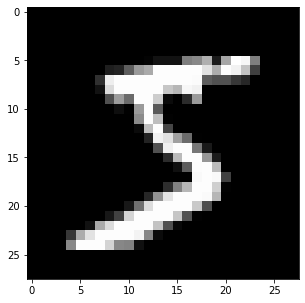

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Defining model

Gaussian noise is added to the images to produce noisy images.



In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        #ncoder layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        #decoder layers
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.sigmoid(self.conv_out(x))
                
        return x
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)



## Training


In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
n_epochs = 20
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    for data in train_loader:
        images, _ = data
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        optimizer.zero_grad()
   
        outputs = model(noisy_imgs)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss 
        ))

C:\Users\Avi\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 1.004443
Epoch: 2 	Training Loss: 0.742105
Epoch: 3 	Training Loss: 0.693678
Epoch: 4 	Training Loss: 0.665888
Epoch: 5 	Training Loss: 0.644353
Epoch: 6 	Training Loss: 0.627858
Epoch: 7 	Training Loss: 0.616685
Epoch: 8 	Training Loss: 0.608049
Epoch: 9 	Training Loss: 0.600977
Epoch: 10 	Training Loss: 0.592236
Epoch: 11 	Training Loss: 0.585163
Epoch: 12 	Training Loss: 0.576393
Epoch: 13 	Training Loss: 0.567594
Epoch: 14 	Training Loss: 0.559484
Epoch: 15 	Training Loss: 0.551754
Epoch: 16 	Training Loss: 0.546811
Epoch: 17 	Training Loss: 0.543324
Epoch: 18 	Training Loss: 0.539642
Epoch: 19 	Training Loss: 0.536630
Epoch: 20 	Training Loss: 0.534147


## Testing and visualizing results

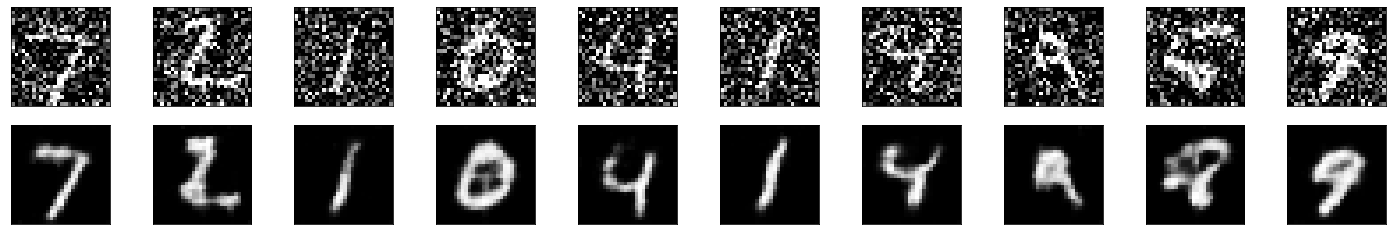

In [8]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)
output = model(noisy_imgs)
noisy_imgs = noisy_imgs.numpy()
output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)